<a href="https://colab.research.google.com/github/YanSym/Data-Science-Projects/blob/master/IMDB_Analise_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: Natural Language Processing
### Analise de sentimentos

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=600 height=350/>

### Imports

In [95]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from collections import Counter
import random

!pip install transformers
!pip install ktrain

import ktrain
from ktrain import text
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

#import kerastuner as kt
#from kerastuner.tuners import BayesianOptimization
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Métodos

In [96]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

In [97]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Dataset

In [98]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

df_train = pd.DataFrame({'review':train_examples, 'sentiment':train_labels})
df_test = pd.DataFrame({'review':test_examples, 'sentiment':test_labels})

movie_reviews = pd.concat([df_train, df_test]).reset_index(drop=True)

movie_reviews['review'] = movie_reviews['review'].str.decode("utf-8")

print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.1, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


False
(50000, 2)
(5000, 2)


,review,sentiment
41986,I was expecting a lot from Mr.Amitabh Bachan's...,0
33935,"Well, it has to be said that Monster Man is a ...",1
46975,Even though I have great interest in Biblical ...,0
16402,The world is made up two different types of mo...,1
39790,Background info - The movies Octopussy & Never...,1


### Analises

1    2500
0    2500
Name: sentiment, dtype: int64


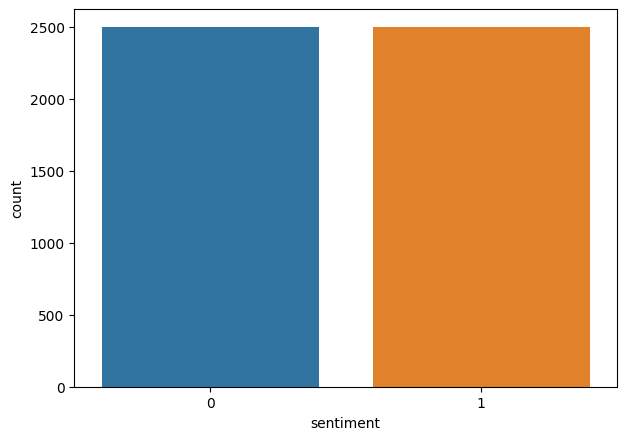

In [99]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

In [100]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
print ('Max len:', movie_reviews['len'].max())
print ('Min len:', movie_reviews['len'].min())
print ('Mean len:', movie_reviews['len'].mean())

Max len: 12930
Min len: 111
Mean len: 1327.1528


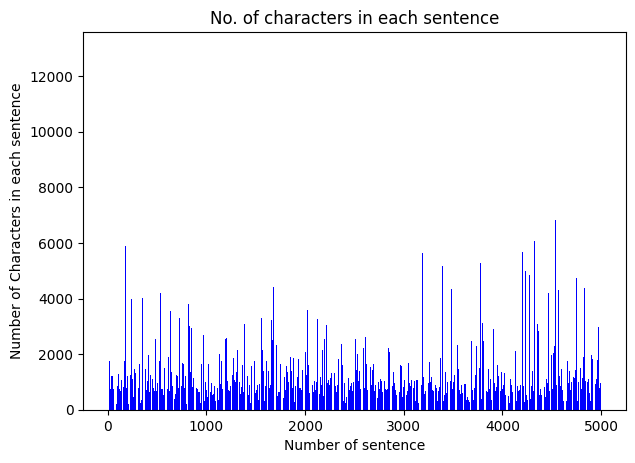

In [101]:
sentences = [len(sent) for sent in movie_reviews['review']]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(sentences)+1), sentences, color = ['blue'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

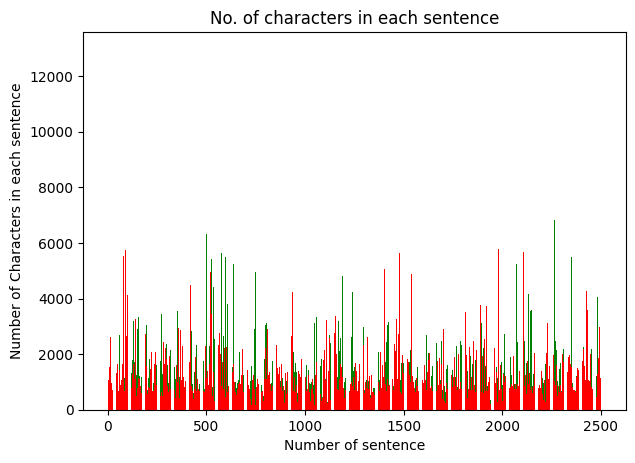

In [102]:
df_positive = movie_reviews.query('sentiment == 1')
df_negative = movie_reviews.query('sentiment == 0')

positive_sentences = [len(sent) for sent in df_positive['review']]
negative_sentences = [len(sent) for sent in df_negative['review']]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(positive_sentences)+1), positive_sentences, color = ['green'])
plt.bar(range(1, len(negative_sentences)+1), negative_sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence',
              xlabel='Number of sentence',
              ylabel='Number of Characters in each sentence');

In [103]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
movie_reviews_short = movie_reviews.query("len <= 200")
movie_reviews_lon = movie_reviews.query("len >= 3_000")

print(movie_reviews['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_short['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_lon['sentiment'].value_counts(dropna=False, normalize=True))

1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.552
0    0.448
Name: sentiment, dtype: float64


### Palavras mais frequentes nas críticas

In [104]:
lista_strings = ' '.join(df_positive['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_positivos = [valor[0] for valor in counter_object.most_common(1000)]

lista_strings = ' '.join(df_negative['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_negativos = [valor[0] for valor in counter_object.most_common(1000)]

lista_positivos = list(set(palavras_mais_aparecem_positivos).difference(set(palavras_mais_aparecem_negativos)))
print ('Positivas:')
print (lista_positivos)

lista_negativos = list(set(palavras_mais_aparecem_negativos).difference(set(palavras_mais_aparecem_positivos)))
print ('Negativas:')
print (lista_negativos)

print ('Palavras positivas:')
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
print (list_positive_words)

print ('Palavras positivas:')
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']
print (list_negative_words)

Positivas:
['meet', 'pure', 'too.', 'Bond', 'brilliant', 'recent', 'dark', 'lovely', 'catch', 'personal', 'directors', 'moving', 'King', 'feelings', 'among', 'series.', 'War', 'enjoyable', 'talented', 'became', 'it!', 'series,', 'fantastic', 'Japanese', 'portrayal', 'elements', 'French', 'emotional', 'Best', 'Sam', 'overall', 'wonderful', 'Jane', 'portrayed', 'hilarious', 'boys', 'highly', 'drug', 'tale', 'telling', 'nature', "He's", "'The", 'popular', 'Great', 'towards', 'memorable', 'war', 'Also,', 'too,', 'Paul', 'today', 'various', 'future', 'ones', 'social', 'her,', 'crime', 'powerful', 'greatest', 'decides', 'miss', 'admit', 'musical', 'parents', 'unique', 'believable', 'deep', 'famous', 'love,', 'murder', 'changes', 'Charlie', 'realistic', 'novel', 'compared', 'control', 'power', 'beauty', 'dance', 'cinematography', 'natural', 'surprisingly', 'question', 'times,', 'sometimes', 'touching', 'herself', 'OF', 'episodes', 'fighting', 'easy', 'city', 'watch.', 'life,', 'funniest', 'he

### Pre-processamento

In [105]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']

### Separa dados em treino e teste

In [106]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Modelo Dummy

In [107]:
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']

def modelo_dummy(texto):
  texto = texto.split(' ')
  if any(x in list_positive_words for x in texto):
    return 1
  elif any(x in list_negative_words for x in texto):
    return 0
  else:
    return random.randint(0, 1)

df_train = pd.DataFrame(X_train, columns=['review'])
df_test = pd.DataFrame(X_test, columns=['review'])

df_train['prediction_dummy'] = df_train['review'].apply(modelo_dummy)
df_test['prediction_dummy'] = df_test['review'].apply(modelo_dummy)

score_train = round(accuracy_score(df_train['prediction_dummy'], y_train), 4)
score_test = round(accuracy_score(df_test['prediction_dummy'], y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.535
Test Accuracy: 0.526


### Tokenizer

In [108]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=200/>

In [109]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [110]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

# score medio
y_pred = classifier.predict_proba(df_train_str)[:, 1]

Train Accuracy: 0.9988
Test Accuracy: 0.799


### Score test

In [111]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

0.9393853698669685
0.09259102304322094


,text,score,rating
0,"The movie was amazing, I loved it, very good",0.939385,Positivo
1,"I hate this movie, it is very bad and terrible",0.092591,Negativo


### BoW (Bag of Words) + Naive Bayes

In [112]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8908
Test Accuracy: 0.688


### BoW (Bag of Words) + Random Forest

In [113]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8212
Test Accuracy: 0.773


## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=200/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=290/>

In [114]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [115]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.9988
Test Accuracy: 0.799


### Tf-Idf (Bag of Words) + Naive Bayes

In [116]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8908
Test Accuracy: 0.688


### Tf-Idf (Bag of Words) + Decision Tree

In [117]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.6738
Test Accuracy: 0.632


### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [118]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8048
Test Accuracy: 0.746


### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [119]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8415
Test Accuracy: 0.756


### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [120]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8725
Test Accuracy: 0.781


### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [121]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.9552
Test Accuracy: 0.795


## Modelos com Embedding

### Regressão Logística

In [122]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5638
Test Accuracy: 0.53


### Naive Bayes

In [123]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.563
Test Accuracy: 0.523


### Árvore de Decisão

In [124]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5868
Test Accuracy: 0.514


### Random Forest

In [125]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8298
Test Accuracy: 0.546


### Modelo simples com Redes Neurais v1 (sem Early Stopping)

Epoch 1/50
25/25 [==============================] - 3s 12ms/step - loss: 329.1710 - acc: 0.4888 - val_loss: 158.7962 - val_acc: 0.5188
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 170.5098 - acc: 0.4997 - val_loss: 102.4936 - val_acc: 0.5450
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 117.5611 - acc: 0.5234 - val_loss: 75.6611 - val_acc: 0.5275
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 86.5933 - acc: 0.5031 - val_loss: 57.4147 - val_acc: 0.5100
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 64.0062 - acc: 0.5116 - val_loss: 43.0416 - val_acc: 0.4950
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 48.8169 - acc: 0.4994 - val_loss: 32.0265 - val_acc: 0.4863
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 35.1956 - acc: 0.5041 - val_loss: 24.0388 - val_acc: 0.5075
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss

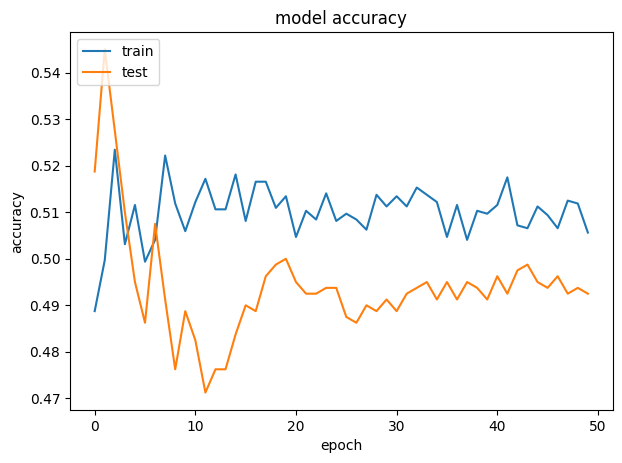

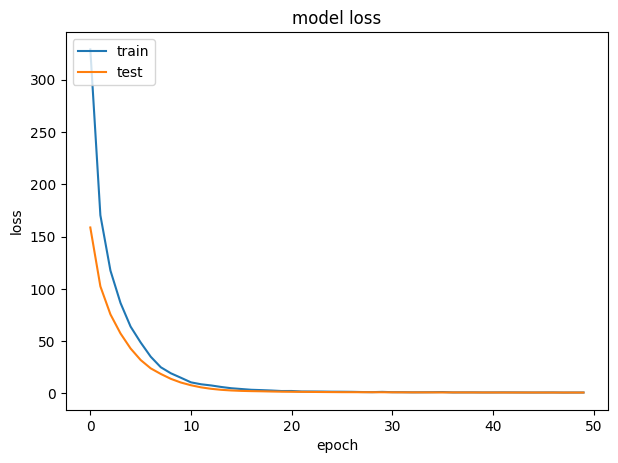

In [126]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

Epoch 1/30
32/32 [==============================] - 1s 9ms/step - loss: 177.9399 - acc: 0.4940 - val_loss: 96.3685 - val_acc: 0.5063

Epoch 00001: val_loss improved from inf to 96.36848, saving model to best_model.h5
Epoch 2/30
32/32 [==============================] - 0s 4ms/step - loss: 74.2347 - acc: 0.5145 - val_loss: 55.7390 - val_acc: 0.5175

Epoch 00002: val_loss improved from 96.36848 to 55.73899, saving model to best_model.h5
Epoch 3/30
32/32 [==============================] - 0s 4ms/step - loss: 37.9803 - acc: 0.5123 - val_loss: 18.5245 - val_acc: 0.5300

Epoch 00003: val_loss improved from 55.73899 to 18.52451, saving model to best_model.h5
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 8.5866 - acc: 0.5077 - val_loss: 3.6194 - val_acc: 0.5175

Epoch 00004: val_loss improved from 18.52451 to 3.61944, saving model to best_model.h5
Epoch 5/30
32/32 [==============================] - 0s 4ms/step - loss: 1.8530 - acc: 0.5065 - val_loss: 2.0891 - val_acc: 

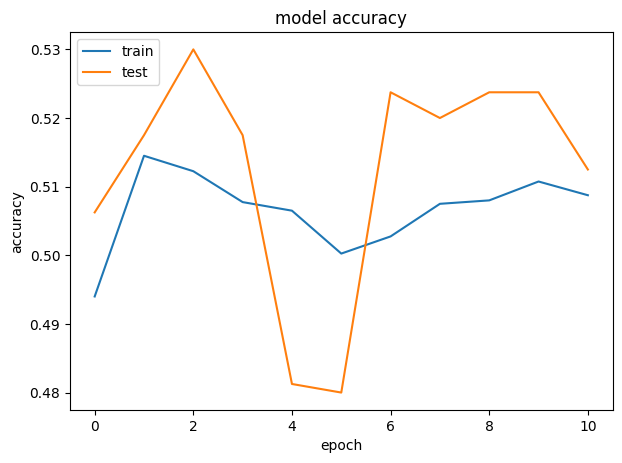

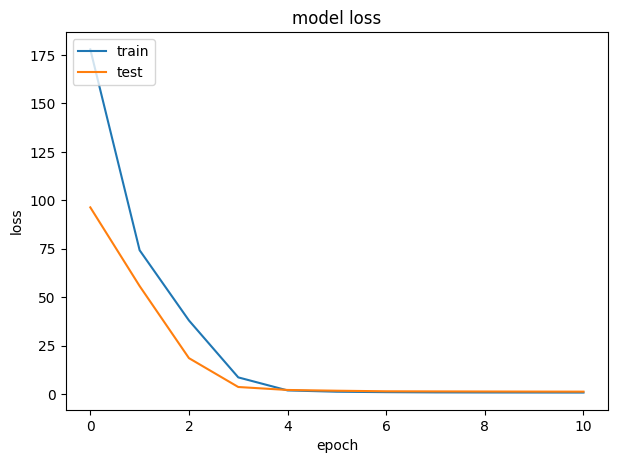

In [127]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Embedding layer (sem Glove)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3516900   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 3,526,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 15ms/step - loss: 0.6905 - acc: 0.5253 - val_loss: 0.6855 - val_acc: 0.5850

Epoch 00001: val_loss improved from inf to 0.68546, saving model to best_model.h5
Epoch 2/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6317 - acc: 0.9087 - val_loss: 0.6678 - val_acc: 0.6675

Epoch 00002: val_loss i

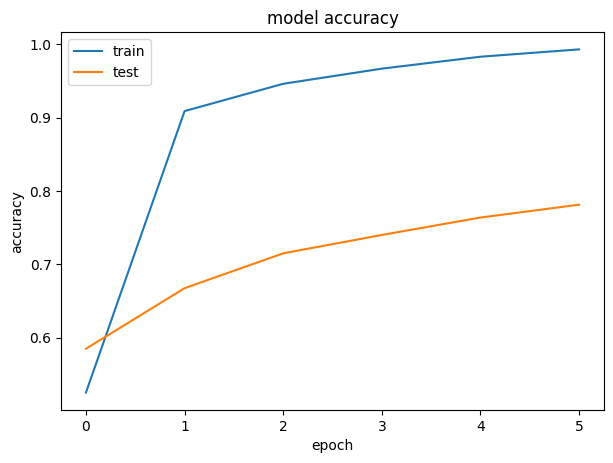

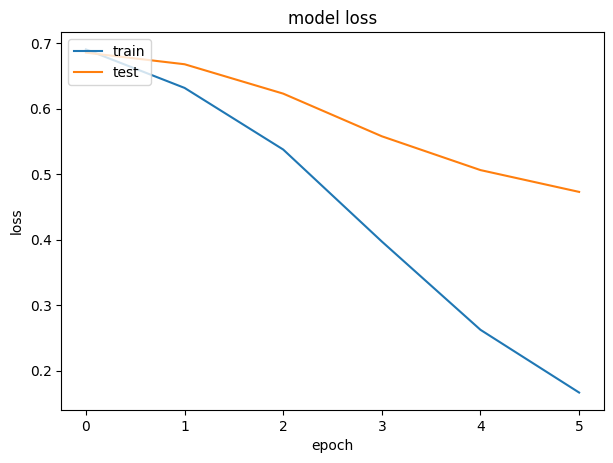

In [128]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Glove

In [129]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 10ms/step - loss: 0.6958 - acc: 0.5684 - val_loss: 0.6780 - val_acc: 0.5913
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5367 - acc: 0.7453 - val_loss: 0.6642 - val_acc: 0.6275
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4450 - acc: 0.8350 - val_loss

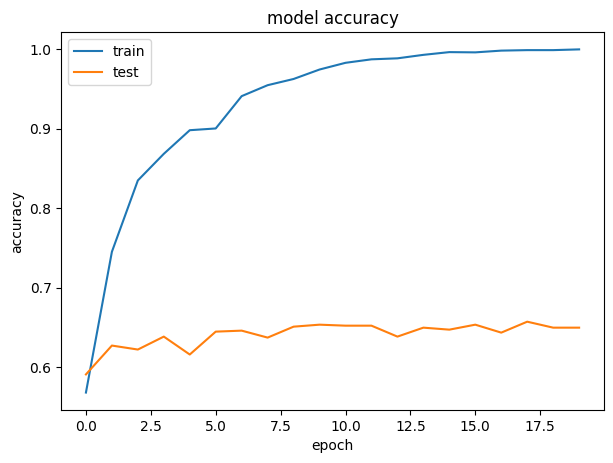

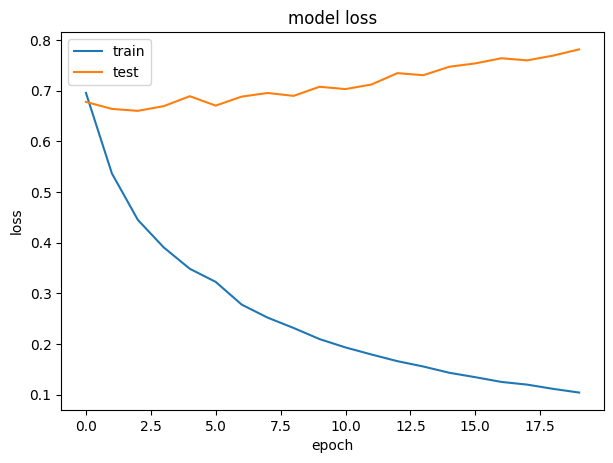

In [130]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Glove (com Early Stopping)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 1s 10ms/step - loss: 0.7647 - acc: 0.5353 - val_loss: 0.7012 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.70118, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.5904 - acc: 0.6759 - val_loss: 0.6930 - val_acc: 0.5987

Epoch 00002: val_lo

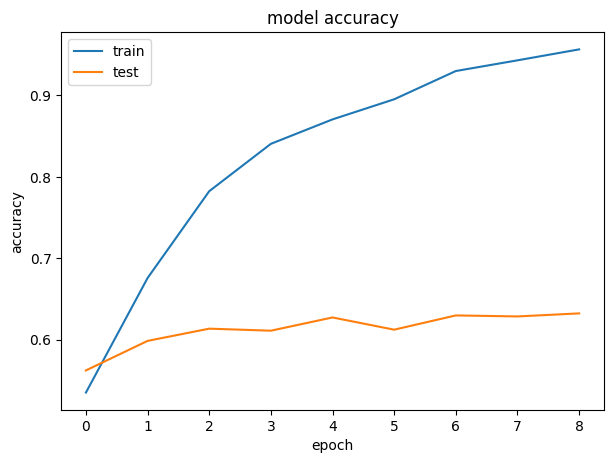

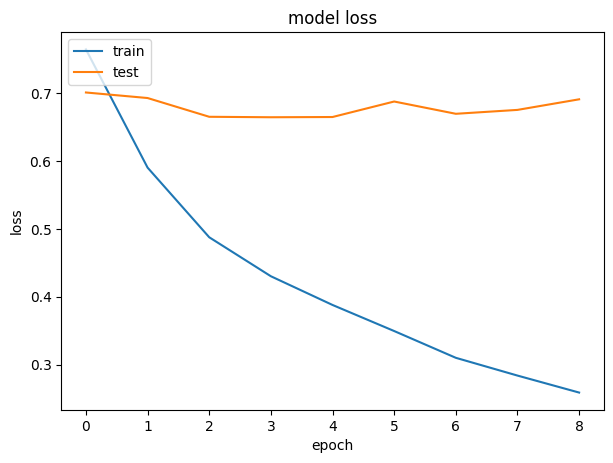

In [131]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 3,581,157
Trainable params: 64,257
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/50
25/25 [==============================] - 28s 20ms/step - loss: 0.6851 - acc: 0.5625 - val_loss: 0.6522 - val_acc: 0.6087
Epoch 2/50
25/25 [==============================] - 0s 10ms/step - loss: 0.5559 - acc: 0.7469 - val_

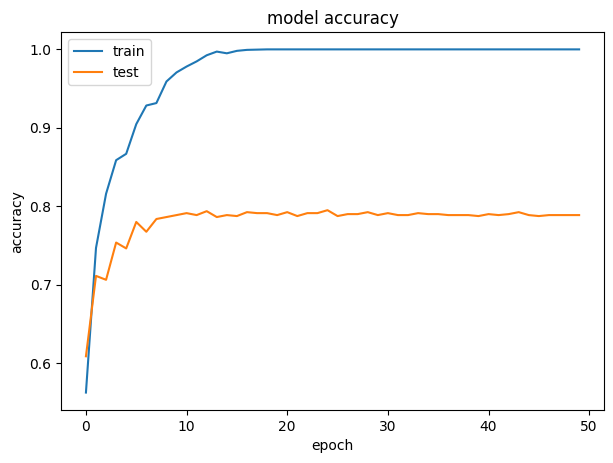

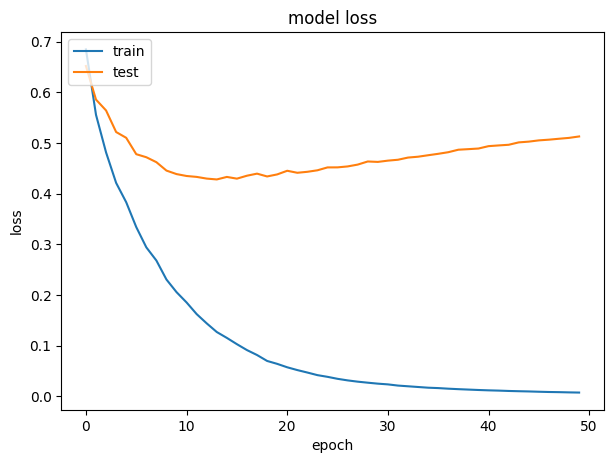

In [132]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN Early Stopping

Epoch 1/30
25/25 [==============================] - 1s 18ms/step - loss: 0.6984 - acc: 0.5444 - val_loss: 0.6554 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 0.65544, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 11ms/step - loss: 0.5519 - acc: 0.7412 - val_loss: 0.5938 - val_acc: 0.6925

Epoch 00002: val_loss improved from 0.65544 to 0.59380, saving model to best_model.h5
Epoch 3/30
25/25 [==============================] - 0s 12ms/step - loss: 0.4780 - acc: 0.8156 - val_loss: 0.5581 - val_acc: 0.7262

Epoch 00003: val_loss improved from 0.59380 to 0.55807, saving model to best_model.h5
Epoch 4/30
25/25 [==============================] - 0s 11ms/step - loss: 0.4153 - acc: 0.8678 - val_loss: 0.5294 - val_acc: 0.7462

Epoch 00004: val_loss improved from 0.55807 to 0.52939, saving model to best_model.h5
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3653 - acc: 0.8919 - val_loss: 0.5009 - val_acc: 0.7563

E

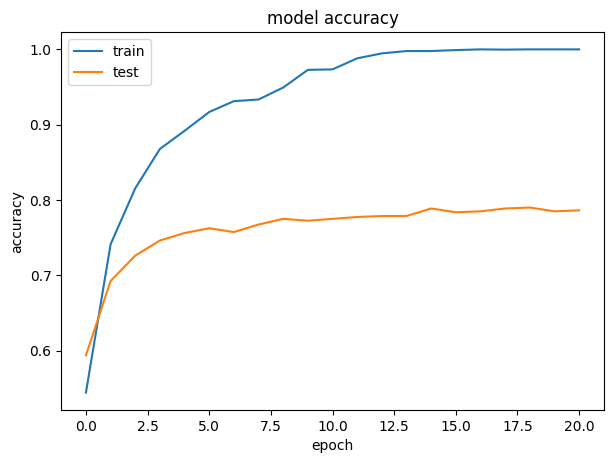

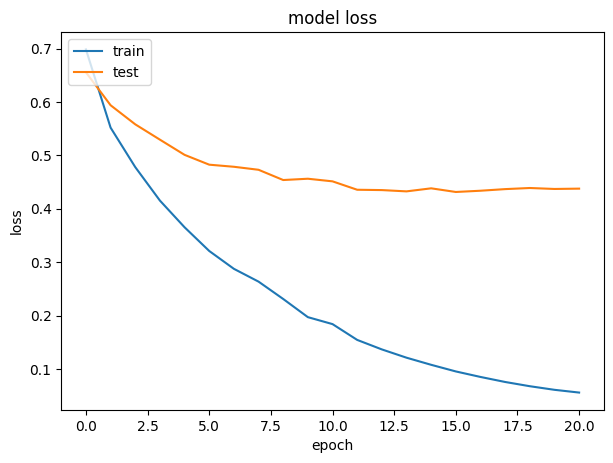

In [133]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### RNN

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 3,546,341
Trainable params: 29,441
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 4s 107ms/step - loss: 0.7223 - acc: 0.5231 - val_loss: 0.6987 - val_acc: 0.5300

Epoch 00001: val_loss improved from inf to 0.69874, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 2s 96ms/step - loss: 0.6837 - acc: 0.5584 - val_loss: 0.7007 - val_acc: 0.5325

Epoch 00002: val_

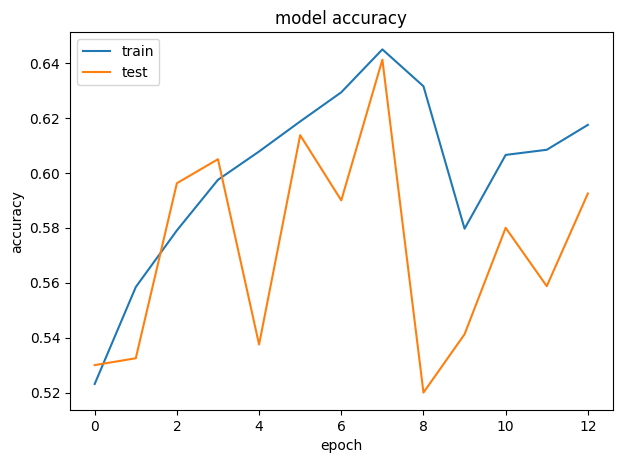

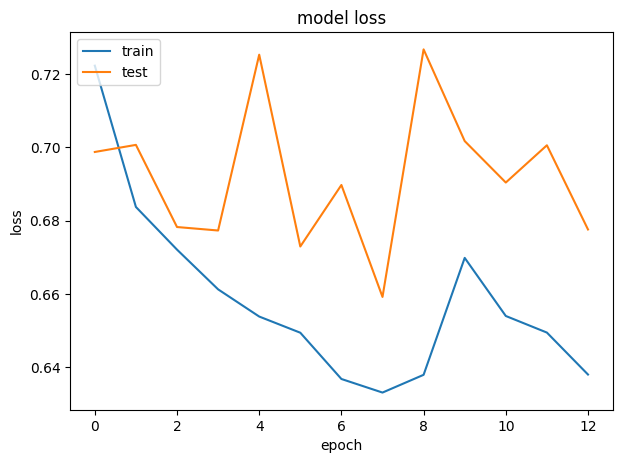

In [134]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/15
25/25 [==============================] - 8s 249ms/step - loss: 0.6815 - acc: 0.5534 - val_loss: 0.6563 - val_acc: 0.6300
Epoch 2/15
25/25 [==============================] - 6s 227ms/step - loss: 0.6396 - acc: 0.6347 - val_loss: 0.6521 - val_acc: 0.5987
Epoch 3/15
25/25 [==============================] - 6s 224ms/step - loss: 0.6038 - acc: 0.6828 - va

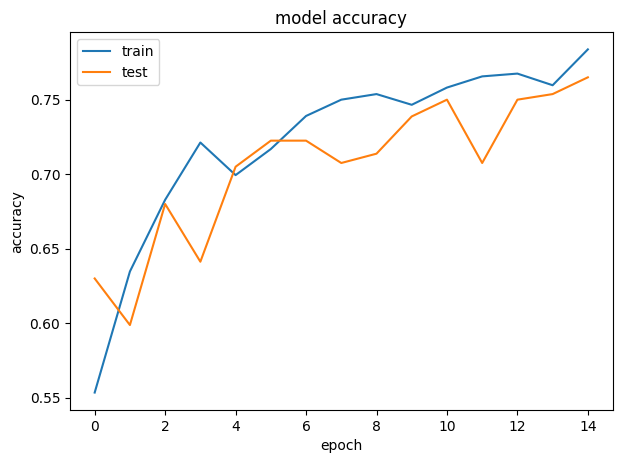

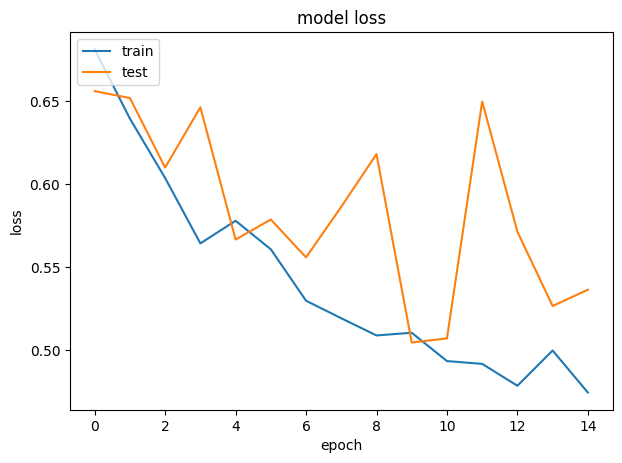

In [135]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM com Early Stopping

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/100
25/25 [==============================] - 8s 235ms/step - loss: 0.6822 - acc: 0.5609 - val_loss: 0.6691 - val_acc: 0.6125

Epoch 00001: val_loss improved from inf to 0.66906, saving model to best_model.h5
Epoch 2/100
25/25 [==============================] - 6s 222ms/step - loss: 0.6371 - acc: 0.6297 - val_loss: 0.6106 - val_acc: 0.6637

Epoch 00002: 

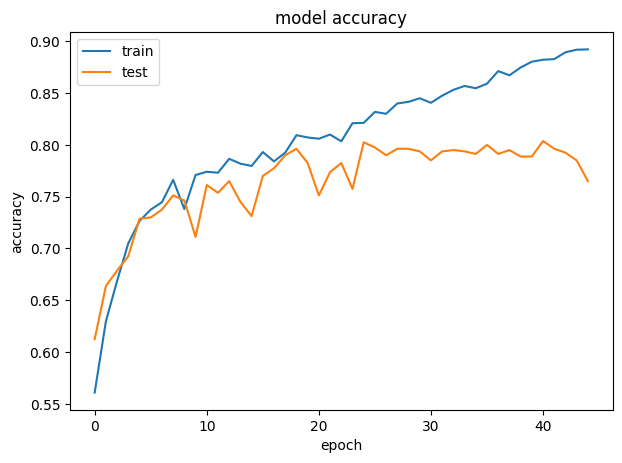

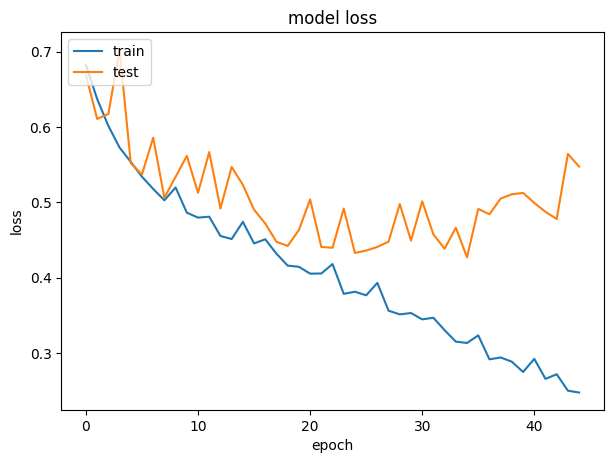

In [136]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)

# load a saved model (best model)
model = load_model('best_model.h5')
print(model.summary())

score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Prediction (sample)

In [137]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

['i have recently watched this film and have decided to comment on it the best way to watch this film is to not expect what you have seen in the past by miyazaki miyazaki is well known for his work on on spirited away and howl moving castle well for western viewers anyway both of them films were kind of similar to each other but at the same time completely different however ponyo is whole different type of story and animation all together the story follows ponyo fish that has the face girl after ponyo runs away from her home at the bottom of the sea she find whole new world she never knew was out there and new trouble as well when she almost caught by fishing boat she was rescued by five year old boy known as sousuke the story then follows the two of them and the pure friendship between boy and fish can ponyo really stay with sousuke forever feel the movie was inspired by the little mermaid and at the same time similar to tonari no totoro the movie is very short and you have very littl

### Prediction (tests)

In [138]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

,text,score,rating
0,"The movie was amazing, I loved it, very good",0.992776,Positivo
1,"I hate this movie, it is very bad and terrible",0.020271,Negativo


Modelo TensorFlow Hub

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_16 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 5s 126ms/step - loss: 0.6694 - accuracy: 0.5249 - val_loss: 0.6196 - val_accuracy: 0.5789
Epoch 2/10
30/30 [==============================] - 4s 118ms/step - loss: 0.5560 - accuracy: 0.6675 - val_loss: 0.5180 - val_accuracy: 0.7253
Epoch 3/10
30/30 [==============================] - 5s 120ms/step - loss: 0.4282 - accu

Modelo Bert

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz',
                                  origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                  extract = True)

IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir = IMDB_DATADIR,
                                                                       classes = ['pos', 'neg'],
                                                                       maxlen = 200,
                                                                       train_test_names = ['train', 'test'],
                                                                       preprocess_mode = 'bert')

model = text.text_classifier(name = 'bert',
                             train_data = (x_train, y_train),
                             preproc = preproc)

learner = ktrain.get_learner(model = model,
                             train_data = (x_train, y_train),
                             val_data = (x_test, y_test),
                             batch_size = 6)

learner.fit_onecycle(lr = 2e-5,
                     epochs = 1)

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 200
done.


begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 3306s 787ms/step - loss: 0.2959 - accuracy: 0.8736 - val_loss: 0.2191 - val_accuracy: 0.9107
